In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andreshat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv(r'../data/train.csv', index_col='id')
test = pd.read_csv(r'../data/test.csv', index_col='id')
submission = pd.read_csv(r'../data/submission.csv')

In [3]:
train.head(2)

,review,sentiment
id,,
0,Action & Adventure.Billie Clark is twenty year...,1
1,I found this early talkie difficult to watch a...,0


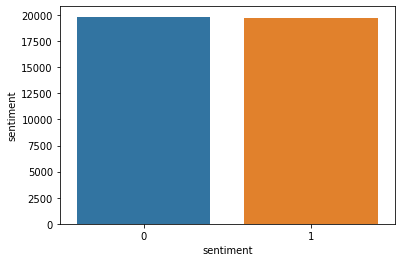

In [4]:
sns.barplot(train['sentiment'], train['sentiment'].value_counts())

In [5]:
train['review'].head()

id
0    Action & Adventure.Billie Clark is twenty year...
1    I found this early talkie difficult to watch a...
2    It was Libby talking to Desmond in the flashba...
3    We fans of Ed Wood tend to be an obsessive bun...
4    Hmm, Hip Hop music to a period western. Modern...
Name: review, dtype: object

In [6]:
def clean_html(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [7]:
def lemmatize_and_stem(lemmatizer, stemmer, sentence):
    word_list = nltk.word_tokenize(sentence)
    output = ' '.join([lemmatizer.lemmatize(stemmer.stem(w)) for w in word_list])
    return output

In [8]:
def text_preprocessing(df_old, columns):
    df = df_old
    for col in columns:
#         To lower
        df[col] = df[col].apply(lambda x: x.lower())
#         Remove html tags
        df[col] = df[col].apply(lambda x: clean_html(x))
#         Replace punctuation with whitespaces
        df[col] = df[col].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))
#         Remove numbers
        df[col] = df[col].apply(lambda x: re.sub(r'\d+', '', x))
#         Split by special-character whitespaces
        df[col] = df[col].apply(lambda x: x.strip())
#         Lemmatization and Stemming
        df[col] = df[col].apply(lambda x: lemmatize_and_stem(WordNetLemmatizer(), PorterStemmer(), x))
    return df

In [9]:
preprocessed_train = train
preprocessed_train = text_preprocessing(preprocessed_train, ['review'])

In [10]:
preprocessed_train['review'][0]

'action adventur billi clark is twenti year old veri pretti and without a care in the world until a brutal street gang violat her life and she turn into an alley cat bent on reveng when the gang attack her grandpar hous and her car billi use her black belt prowess to fight them off but at the same time she earn their hatr and she and her grandpar are mark for vengenc when her grandpar lose their live to the brutal thug billi becom like a cat stalk her prey and no prison polic forc boyfriend or crook judg can get in the way of her aveng claw she s a one woman vigilant squad a martial art queen a crack shot with no merci she s the alley cat watch for the dramat end versu the gang leader rate r for nuditi violenc other film with karin mani actress filmographi aveng angel jani soon lee from here to etern mini tv seri tawni filmographi a actress stunt filmographi aveng angel stunt p s she should have been catwoman in the batman movi'

In [11]:
preprocessed_test = test
preprocessed_test = text_preprocessing(test, ['review'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
tfidf = TfidfVectorizer(min_df=5)
train_tfidf = tfidf.fit_transform(preprocessed_train['review'])
train_tfidf.shape

(39582, 22059)

In [14]:
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import StratifiedKFold

In [15]:
skf = StratifiedKFold(n_splits=10)

model_linear_svc = LinearSVC()
model_svc = SVC()
model_nb = GaussianNB()
model_multinomial_nb = MultinomialNB()

In [16]:
# models = [model_linear_svc]
# models = [model_linear_svc, model_svc, model_nb, model_multinomial_nb]
models = [model_linear_svc, model_nb, model_multinomial_nb]

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
tfidf_train = train_tfidf
tfidf_y_train = preprocessed_train['sentiment']

In [19]:
# results = []
# names = []

In [20]:
# for model in models:
#         print(str(model))
#         cv_results = cross_val_score(model, X_train, y_train, cv=skf)
        
#         print(cv_results)
#         results.append(cv_results)
#         names.append(str(model))

In [21]:
# results

In [23]:
cv_results = cross_val_score(model_linear_svc, tfidf_train, tfidf_y_train, cv=skf)

In [24]:
cv_results

array([0.90300581, 0.89214448, 0.88453765, 0.88858009, 0.89540172,
       0.8981809 , 0.89767559, 0.88832744, 0.88858009, 0.89186458])

In [25]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [26]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_train, tfidf_y_train, test_size = 0.3, random_state = 101)

In [35]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.arange(0.01, 1)}

In [36]:
model_linear_svc.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [37]:
grid = GridSearchCV(model_linear_svc, param_grid, refit = True, verbose = 2) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 823, in _get_liblinear_solver_type
    % (error_string, penalty, loss, dual))
ValueError: Unsupport

[CV] ............................... C=0.01, penalty=l2, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': array([0.01]), 'penalty': ['l1', 'l2']},
             verbose=2)

In [38]:
print(grid.best_estimator_)

LinearSVC(C=0.01)


In [39]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      5966
           1       0.84      0.89      0.86      5909

    accuracy                           0.86     11875
   macro avg       0.86      0.86      0.86     11875
weighted avg       0.86      0.86      0.86     11875



In [ ]:
model_linear_svc.fit(tfidf_train, tfidf_y_train)

In [ ]:
tfidf_test = tfidf.transform(preprocessed_test['review'])

In [ ]:
tfidf_test.shape

In [ ]:
y_pred = model_linear_svc.predict(tfidf_test)

In [ ]:
submission['sentiment'] = y_pred

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission_linear_svm.csv", index=False)